# 0 Libraries and set up 

In [1]:
import os
os.chdir('../') # insures use of models folder as python module 
# Any figures saved or data pickled in the current working 
# directly will be saved up one folder from here.
import pybamm
import models
import numpy as np
import pickle
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['font.size'] =  18.0

In [2]:
def run_simulation(sim,time_in_seconds = 43200):
    time = 0
    while time < time_in_seconds:
        try:
            sim.step(5)
            time+= 5
        except:
            try: 
                sim.step(.1)
                time += .1
            except:
                break
                #try:
                #    sim.step(0.0001)
                #    time += 0.0001
                #except:
                #    break
                    
    return sim

# 1 Cell Cycling

This will help the cell obtain a more realistic initial condition and tests if the cell can predict capacity fade across cycles. 

## 1.1.0 First we obtain the initial conditions and parameters for the 30 degree C cell

In [3]:
# Experimental cell capacity
cap = 0.211

# Parameters taken from Marinescu et al. (2016)
Ms = 32
F = 9.649e4
R = 8.3145
T_30 = 303.15
ar = 0.960
nu = 0.0114

f_h = ((4 ** 2) * Ms * nu / 8)**(1/4)
f_m = ((2 ** 2) * Ms * nu / 4)**(1/2)
f_l = ((1 ** 2) * Ms * nu / 2)**(1/2)

# Current at 0.1C rate
I = -cap*0.1

# New standard potentials
EL0 = 1.9
EM0 = 2.41
EH0 = 2.43

# New exchange current constants
ih0 = 5
im0 = 5
il0 = 5

# Saturation mass constant
S_star_30 = 1e-6

# dissolution rate
kd_30 = 5000

# shuttle rate
ks_30 = 1e-5

# Initial value of Precipitated sulfur at start of charge
Sp_initial_cha_30 = .43

# Initial value of S1 anion at start of charge
S1_initial_cha_30 = 1e-3

# Initial value of voltage at start of charge
V_initial_cha = 2.0

# Function for which root yields i_L = I
def S2_func(S1):
    constant = np.exp((2*F/(R*T_30))*(V_initial_cha - (2*R*T_30/F)*np.arcsinh(I/(-2*ar*il0)) - EL0 ))/(f_l**2)
    return constant*(S1**2)

# Function from equation (9b) in Cornish & Marinescu (2021)
def S4_func(S2):
    constant = np.exp((2*F/(R*T_30))*(V_initial_cha  - EM0 ))/(f_m**2)
    return constant*(S2**2)

# Function from equation (9a) in Cornish & Marinescu (2021)
def S8_func(S4):
    constant = np.exp((4*F/(R*T_30))*(V_initial_cha - EH0 ))/(f_h**4)
    return constant*(S4**2)

# Initial charge value of S2
S2_initial_cha_30 = S2_func(S1_initial_cha_30)

# Initial charge value of S2
S4_initial_cha_30 = S4_func(S2_initial_cha_30)

# Initial charge value of S2
S8_initial_cha_30 = S8_func(S4_initial_cha_30)

# Initial high plateau potential 
EH_30 = EH0 + (R*T_30)*np.log(f_h*(S8_initial_cha_30**(1/4))/(S4_initial_cha_30**(1/2)))/(F)

# Initial high plateau over-potential
eta_H_30 = V_initial_cha - EH_30

# Initial high plateau current
iH_30 = -2*ih0*ar*np.sinh(F*eta_H_30/(2*R*T_30))

# Initial middle plateau potential
EM_30 = EM0 + (R*T_30)*np.log(f_m*(S4_initial_cha_30**(1/2))/S2_initial_cha_30)/(F)

# Initial middle plateau over-potentia
eta_M_30 = V_initial_cha - EM_30

# Initial middle plateau current
iM_30 = -2*im0*ar*np.sinh(F*eta_M_30/(2*R*T_30))

# Initial low plateau potential
EL_30 = EL0 + (R*T_30/F)*np.log(f_l*(S2_initial_cha_30**(1/2))/S1_initial_cha_30)

# Initial low plateau over-potentia
eta_L_30 = V_initial_cha - EL_30

# Initial low plateau current
iL_30 = -2*il0*ar*np.sinh(F*eta_L_30/(2*R*T_30))

print('The initial charge value of precipitated sulfur is {} g'.format(Sp_initial_cha_30))
print('The initial charge value of S1 anion is {} g'.format(S1_initial_cha_30))
print('The initial charge value of S2 anion is {} g'.format(S2_initial_cha_30))
print('The initial charge value of S4 anion is {} g'.format(S4_initial_cha_30))
print('The initial charge value of S8 anion is {} g'.format(S8_initial_cha_30))
print('The initial charge value of voltage is {} V'.format(V_initial_cha))
print('The initial charge value of the high plateau potential is {} V'.format(EH_30))
print('The initial charge value of the high plateau over-potential is {} V'.format(eta_H_30))
print('The initial charge value of the high plateau current is {} A'.format(iH_30))
print('The initial charge value of the middle plateau potential is {} V'.format(EM_30))
print('The initial charge value of the middle plateau over-potential is {} V'.format(eta_M_30))
print('The initial charge value of the middle plateau current is {} A'.format(iM_30))
print('The initial charge value of the low plateau potential is {} V'.format(EL_30))
print('The initial charge value of the low plateau over-potential is {} V'.format(eta_L_30))
print('The initial charge value of the low plateau current is {} A'.format(iL_30))

The initial charge value of precipitated sulfur is 0.43 g
The initial charge value of S1 anion is 0.001 g
The initial charge value of S2 anion is 0.011487966377185257 g
The initial charge value of S4 anion is 8.425161409668764e-18 g
The initial charge value of S8 anion is 2.467917664668259e-63 g
The initial charge value of voltage is 2.0 V
The initial charge value of the high plateau potential is 2.0 V
The initial charge value of the high plateau over-potential is 0.0 V
The initial charge value of the high plateau current is -0.0 A
The initial charge value of the middle plateau potential is 2.0 V
The initial charge value of the middle plateau over-potential is 0.0 V
The initial charge value of the middle plateau current is -0.0 A
The initial charge value of the low plateau potential is 1.999885170817739 V
The initial charge value of the low plateau over-potential is 0.00011482918226102257 V
The initial charge value of the low plateau current is -0.02110000000001298 A


## 1.1.1 First Charge

In [4]:
# Instantiate the model
model_30 = models.Cornish2021()


# Obtain model parameter dictionary
param_30 = model_30.default_parameter_values

# Update the parameters for charge
param_30.update(
    {
        "Current function [A]": I,
        "Initial Condition for Terminal Voltage [V]": V_initial_cha,
        "Initial Condition for S8 ion [g]" : S8_initial_cha_30,
        "Initial Condition for S4 ion [g]" : S4_initial_cha_30,
        "Initial Condition for S2 ion [g]" : S2_initial_cha_30,
        "Initial Condition for S ion [g]" : S1_initial_cha_30,
        "Initial Condition for Precipitated Sulfur [g]" : Sp_initial_cha_30,
        "Lower voltage cut-off [V]" : 1.2,
        "Upper voltage cut-off [V]" : 2.5,
        "Standard Potential L [V]" : EL0,
        "Standard Potential M [V]" : EM0,
        "Standard Potential H [V]" : EH0,
        "Exchange current density L [A.m-2]": il0,
        "Exchange current density M [A.m-2]": im0,
        "Exchange current density H [A.m-2]": ih0,
        "Active reaction area per cell [m2]":ar,
        "S saturation mass [g]": S_star_30,
        'Shuttle rate coefficient during charge [s-1]': ks_30,
        'Dissolution rate [s-1]': kd_30,
        'Reference Temperature [K]': T_30
        }
)

# Instantiate simulation object 
sim_30_cha1 = pybamm.Simulation(
    model_30,
    parameter_values = param_30,
    solver=pybamm.CasadiSolver(
        atol=1e-6,
        rtol=1e-6,
        dt_max = .01,
        extra_options_setup={"max_step_size": 0.1}, 
        max_step_decrease_count = 15,
    ),
)

# Define the time cut-off for charging in second
time_in_seconds = 12*int(3600/0.1)

# Simulate the model 
#sim_30_cha1.solve([0,time_in_seconds]);


sim_30_cha1 = run_simulation(sim_30_cha1)

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

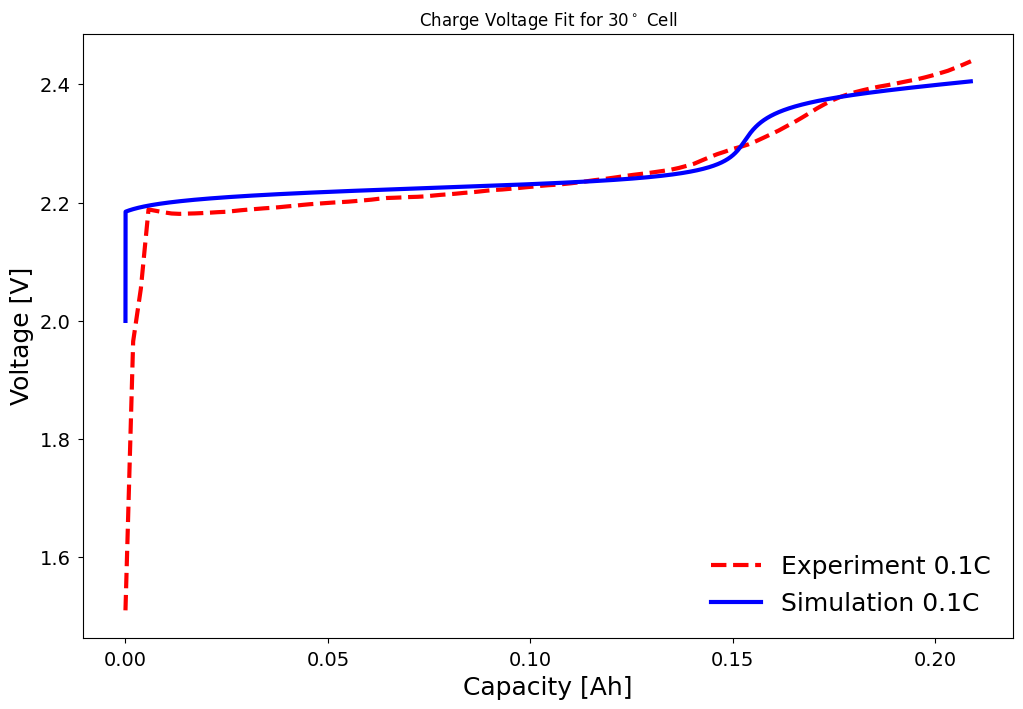

In [5]:
# get experimental data
filename = 'Cornish & Marinescu (2021)/vol_data'
infile = open(filename,'rb')
data_dict = pickle.load(infile)
infile.close()

discharge_data = data_dict['discharge']
charge_data = data_dict['charge']

plt.plot(charge_data['30']['capacity'],charge_data['30']['internal voltage'], linestyle='--')

index_30 = len(sim_30_cha1.solution.t[sim_30_cha1.solution.t*0.0211/3600 < charge_data['30']['capacity'][-1]])

capacity = abs(I)*sim_30_cha1.solution.t[:index_30]/3600
voltage = sim_30_cha1.solution['Terminal voltage [V]'].entries[:index_30]


plt.plot(capacity, voltage)
plt.title("Charge Voltage Fit for $30^\circ$ Cell")
plt.legend(['Experiment 0.1C', 'Simulation 0.1C'], loc = 'lower right', frameon=False)
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]');

## 1.1.2 First Discharge 

In [6]:
loc = index_30
S1_initial_30_dis1 = sim_30_cha1.solution['S [g]'].entries[loc]
S2_initial_30_dis1 = sim_30_cha1.solution['S2 [g]'].entries[loc]
S4_initial_30_dis1 = sim_30_cha1.solution['S4 [g]'].entries[loc]
S8_initial_30_dis1 = sim_30_cha1.solution['S8 [g]'].entries[loc]
Sp_initial_30_dis1 = sim_30_cha1.solution['Precipitated Sulfur [g]'].entries[loc]
V_initial_30_dis1 = sim_30_cha1.solution['Terminal voltage [V]'].entries[loc]
print(S8_initial_30_dis1)
print(S4_initial_30_dis1)
print(S2_initial_30_dis1)
print(S1_initial_30_dis1)
print(Sp_initial_30_dis1)
print(V_initial_30_dis1)

0.0006987277172672221
0.15073806137527931
0.2828306309436993
9.071317639008337e-10
0.008220545433794838
2.405203119936759


In [7]:
model_30_dis1 = models.Cornish2021()

param_30_dis1 = model_30_dis1.default_parameter_values

# dissolution rate
kp_30 = 50
param_30_dis1.update(
    {
        "Current function [A]": 2*.0211,
        "Initial Condition for Terminal Voltage [V]": V_initial_30_dis1,
        "Initial Condition for S8 ion [g]" : S8_initial_30_dis1,
        "Initial Condition for S4 ion [g]" : S4_initial_30_dis1,
        "Initial Condition for S2 ion [g]" : S2_initial_30_dis1,
        "Initial Condition for S ion [g]" : S1_initial_30_dis1,
        "Initial Condition for Precipitated Sulfur [g]" : Sp_initial_30_dis1,
        "Lower voltage cut-off [V]" : 1.2,
        "Upper voltage cut-off [V]" : 2.5,
        "Standard Potential L [V]" : EL0,
        "Standard Potential M [V]" : EM0,
        "Standard Potential H [V]" : EH0,
        "Exchange current density L [A.m-2]": il0,
        "Exchange current density M [A.m-2]": im0,
        "Exchange current density H [A.m-2]": ih0,
        "Active reaction area per cell [m2]":ar,
        "S saturation mass [g]": S_star_30,
        'Precipitation rate [s-1]': kp_30,
        'Reference Temperature [K]': T_30
        }
)


sim_30_dis1 = pybamm.Simulation(
    model_30_dis1,
    parameter_values = param_30_dis1,
    solver=pybamm.CasadiSolver(
        atol=1e-8,
        rtol=1e-6,
        dt_max = .01,
        #extra_options_setup={"max_step_size": 0.1}, 
        max_step_decrease_count = 15,
    ),
)

sim_30_dis1 = run_simulation(sim_30_dis1, time_in_seconds = 18220)

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 18218.9 and h

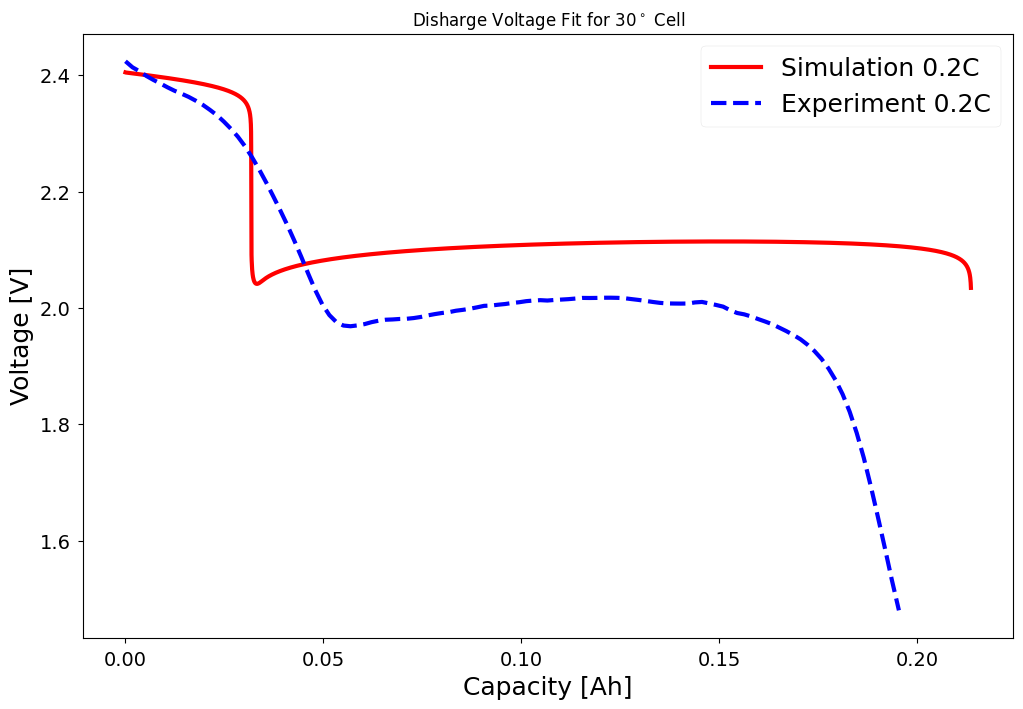

In [8]:
plt.plot(sim_30_dis1.solution.t*0.0422/3600, sim_30_dis1.solution['Terminal voltage [V]'].entries)

# get experimental data
filename = 'Cornish & Marinescu (2021)/vol_data'
infile = open(filename,'rb')
data_dict = pickle.load(infile)
infile.close()

discharge_data = data_dict['discharge']
charge_data = data_dict['charge']

plt.plot(discharge_data['30']['capacity'],discharge_data['30']['internal voltage'], linestyle='--')

plt.title("Disharge Voltage Fit for $30^\circ$ Cell")
plt.legend(["Simulation 0.2C","Experiment 0.2C" ])
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]');

## 1.1.3 Second Charge

In [9]:
loc = -1
S1_initial_30_cha2 = sim_30_dis1.solution['S [g]'].entries[loc]
S2_initial_30_cha2 = sim_30_dis1.solution['S2 [g]'].entries[loc]
S4_initial_30_cha2 = sim_30_dis1.solution['S4 [g]'].entries[loc]
S8_initial_30_cha2 = sim_30_dis1.solution['S8 [g]'].entries[loc]
Sp_initial_30_cha2 = sim_30_dis1.solution['Precipitated Sulfur [g]'].entries[loc]
V_initial_30_cha2 = sim_30_dis1.solution['Terminal voltage [V]'].entries[loc]
print(S8_initial_30_cha2)
print(S4_initial_30_cha2)
print(S2_initial_30_cha2)
print(S1_initial_30_cha2)
print(Sp_initial_30_cha2)
print(V_initial_30_cha2)

2.9177539145075095e-66
2.0336355561810875e-20
0.00014954542964544176
2.9860175533266144e-05
0.4423085607719751
2.0346784185006097


In [10]:
# Instantiate the model
model_30 = models.Cornish2021()


# Obtain model parameter dictionary
param_30 = model_30.default_parameter_values

# Update the parameters for charge
param_30.update(
    {
        "Current function [A]": I,
        "Initial Condition for Terminal Voltage [V]": V_initial_30_cha2,
        "Initial Condition for S8 ion [g]" : S8_initial_30_cha2,
        "Initial Condition for S4 ion [g]" : S4_initial_30_cha2,
        "Initial Condition for S2 ion [g]" : S2_initial_30_cha2,
        "Initial Condition for S ion [g]" : S1_initial_30_cha2,
        "Initial Condition for Precipitated Sulfur [g]" : Sp_initial_30_cha2,
        "Lower voltage cut-off [V]" : 1.2,
        "Upper voltage cut-off [V]" : 2.5,
        "Standard Potential L [V]" : EL0,
        "Standard Potential M [V]" : EM0,
        "Standard Potential H [V]" : EH0,
        "Exchange current density L [A.m-2]": il0,
        "Exchange current density M [A.m-2]": im0,
        "Exchange current density H [A.m-2]": ih0,
        "Active reaction area per cell [m2]":ar,
        "S saturation mass [g]": S_star_30,
        'Shuttle rate coefficient during charge [s-1]': ks_30,
        'Dissolution rate [s-1]': kd_30,
        'Reference Temperature [K]': T_30
        }
)

# Instantiate simulation object 
sim_30_cha2 = pybamm.Simulation(
    model_30,
    parameter_values = param_30,
    solver=pybamm.CasadiSolver(
        atol=1e-6,
        rtol=1e-6,
        dt_max = .01,
        extra_options_setup={"max_step_size": 0.1}, 
        max_step_decrease_count = 15,
    ),
)

# Define the time cut-off for charging in second
time_in_seconds = 12*int(3600/0.1)

# Simulate the model 
#sim_30_cha1.solve([0,time_in_seconds]);


sim_30_cha2 = run_simulation(sim_30_cha2)

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

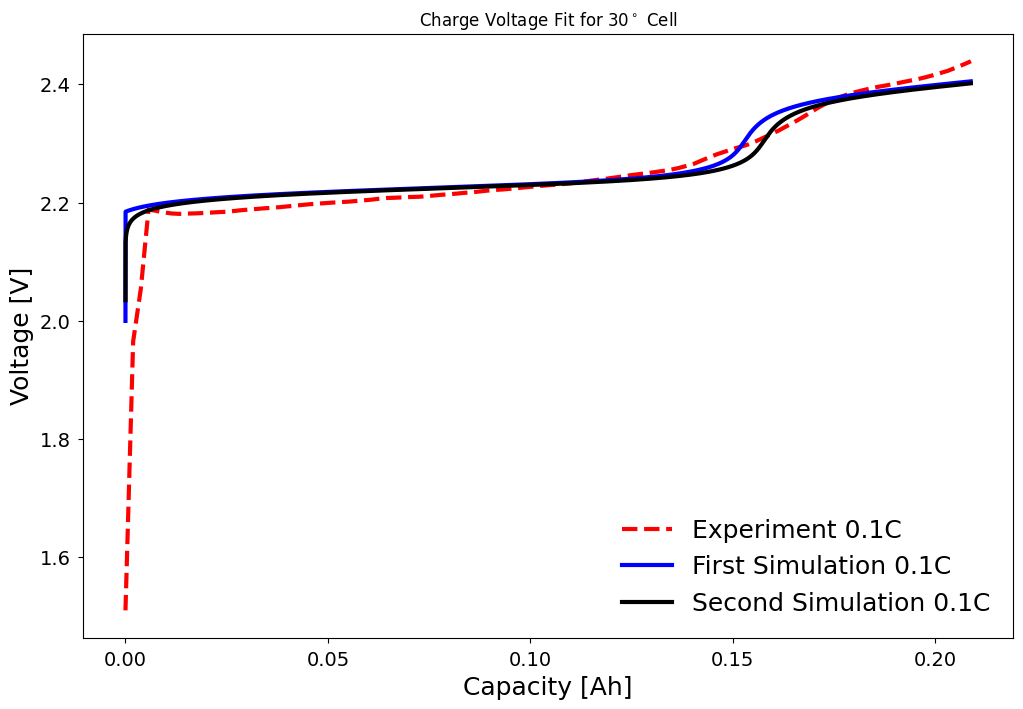

In [11]:
# get experimental data
filename = 'Cornish & Marinescu (2021)/vol_data'
infile = open(filename,'rb')
data_dict = pickle.load(infile)
infile.close()

discharge_data = data_dict['discharge']
charge_data = data_dict['charge']

plt.plot(charge_data['30']['capacity'],charge_data['30']['internal voltage'], linestyle='--')

index_30 = len(sim_30_cha1.solution.t[sim_30_cha1.solution.t*0.0211/3600 < charge_data['30']['capacity'][-1]])
capacity = abs(I)*sim_30_cha1.solution.t[:index_30]/3600
voltage = sim_30_cha1.solution['Terminal voltage [V]'].entries[:index_30]
plt.plot(capacity, voltage)

index_30 = len(sim_30_cha2.solution.t[sim_30_cha2.solution.t*0.0211/3600 < charge_data['30']['capacity'][-1]])
capacity = abs(I)*sim_30_cha2.solution.t[:index_30]/3600
voltage = sim_30_cha2.solution['Terminal voltage [V]'].entries[:index_30]
plt.plot(capacity, voltage)

plt.title("Charge Voltage Fit for $30^\circ$ Cell")
plt.legend(['Experiment 0.1C', 'First Simulation 0.1C', 'Second Simulation 0.1C'], loc = 'lower right', frameon=False)
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]');

## 1.1.4 Second Discharge 

In [12]:
loc = index_30
S1_initial_30_dis2 = sim_30_cha2.solution['S [g]'].entries[loc]
S2_initial_30_dis2 = sim_30_cha2.solution['S2 [g]'].entries[loc]
S4_initial_30_dis2 = sim_30_cha2.solution['S4 [g]'].entries[loc]
S8_initial_30_dis2 = sim_30_cha2.solution['S8 [g]'].entries[loc]
Sp_initial_30_dis2 = sim_30_cha2.solution['Precipitated Sulfur [g]'].entries[loc]
V_initial_30_dis2 = sim_30_cha2.solution['Terminal voltage [V]'].entries[loc]
print(S8_initial_30_dis2)
print(S4_initial_30_dis2)
print(S2_initial_30_dis2)
print(S1_initial_30_dis2)
print(Sp_initial_30_dis2)
print(V_initial_30_dis2)

0.00032052532748269954
0.13182350244275046
0.3005268889821805
1.0626848046962666e-09
0.00981704856207253
2.4018642339221845


In [13]:
model_30_dis2 = models.Cornish2021()

param_30_dis2 = model_30_dis2.default_parameter_values

# dissolution rate
kp_30 = 50
param_30_dis2.update(
    {
        "Current function [A]": 2*.0211,
        "Initial Condition for Terminal Voltage [V]": V_initial_30_dis2,
        "Initial Condition for S8 ion [g]" : S8_initial_30_dis2,
        "Initial Condition for S4 ion [g]" : S4_initial_30_dis2,
        "Initial Condition for S2 ion [g]" : S2_initial_30_dis2,
        "Initial Condition for S ion [g]" : S1_initial_30_dis2,
        "Initial Condition for Precipitated Sulfur [g]" : Sp_initial_30_dis2,
        "Lower voltage cut-off [V]" : 1.2,
        "Upper voltage cut-off [V]" : 2.5,
        "Standard Potential L [V]" : EL0,
        "Standard Potential M [V]" : EM0,
        "Standard Potential H [V]" : EH0,
        "Exchange current density L [A.m-2]": il0,
        "Exchange current density M [A.m-2]": im0,
        "Exchange current density H [A.m-2]": ih0,
        "Active reaction area per cell [m2]":ar,
        "S saturation mass [g]": S_star_30,
        'Precipitation rate [s-1]': kp_30,
        'Reference Temperature [K]': T_30
        }
)


sim_30_dis2 = pybamm.Simulation(
    model_30_dis2,
    parameter_values = param_30_dis2,
    solver=pybamm.CasadiSolver(
        atol=1e-8,
        rtol=1e-6,
        dt_max = .01,
        #extra_options_setup={"max_step_size": 0.1}, 
        max_step_decrease_count = 15,
    ),
)

sim_30_dis2 = run_simulation(sim_30_dis2, time_in_seconds = 17820)

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 17813.9 and h

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 17817 and h =

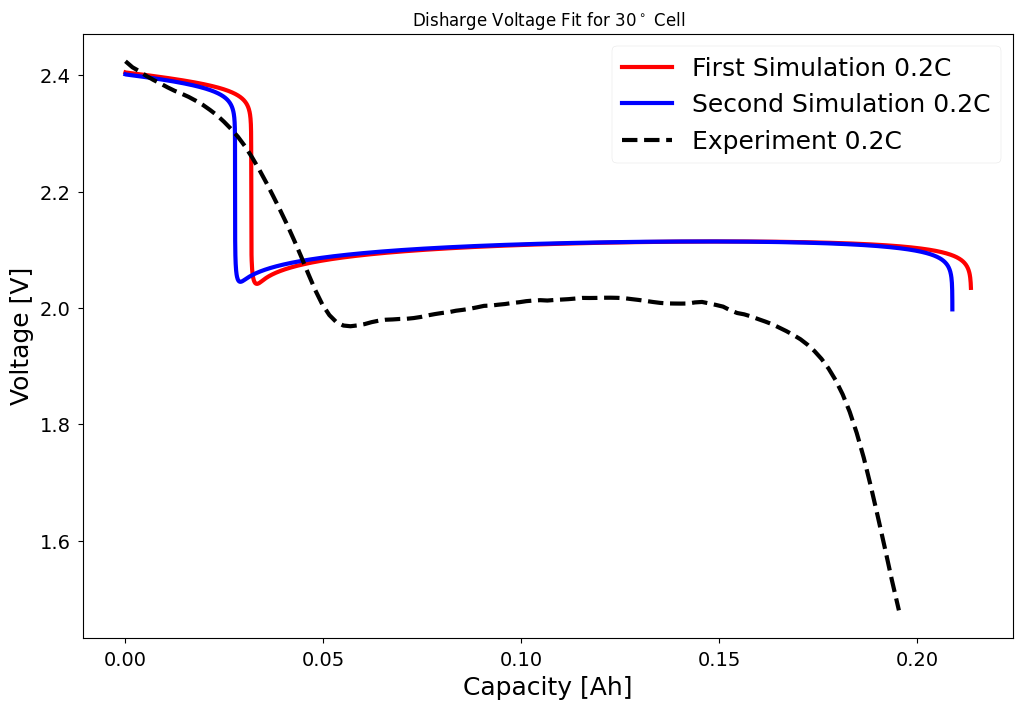

In [14]:
plt.plot(sim_30_dis1.solution.t*0.0422/3600, sim_30_dis1.solution['Terminal voltage [V]'].entries)

plt.plot(sim_30_dis2.solution.t*0.0422/3600, sim_30_dis2.solution['Terminal voltage [V]'].entries)

# get experimental data
filename = 'Cornish & Marinescu (2021)/vol_data'
infile = open(filename,'rb')
data_dict = pickle.load(infile)
infile.close()

discharge_data = data_dict['discharge']
charge_data = data_dict['charge']

plt.plot(discharge_data['30']['capacity'],discharge_data['30']['internal voltage'], linestyle='--')

plt.title("Disharge Voltage Fit for $30^\circ$ Cell")
plt.legend(["First Simulation 0.2C","Second Simulation 0.2C","Experiment 0.2C" ])
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]');

## 1.1.5 Third Charge 

In [15]:
loc = -1
S1_initial_30_cha3 = sim_30_dis2.solution['S [g]'].entries[loc]
S2_initial_30_cha3 = sim_30_dis2.solution['S2 [g]'].entries[loc]
S4_initial_30_cha3 = sim_30_dis2.solution['S4 [g]'].entries[loc]
S8_initial_30_cha3 = sim_30_dis2.solution['S8 [g]'].entries[loc]
Sp_initial_30_cha3 = sim_30_dis2.solution['Precipitated Sulfur [g]'].entries[loc]
V_initial_30_cha3 = sim_30_dis2.solution['Terminal voltage [V]'].entries[loc]
print(S8_initial_30_cha3)
print(S4_initial_30_cha3)
print(S2_initial_30_cha3)
print(S1_initial_30_cha3)
print(Sp_initial_30_cha3)
print(V_initial_30_cha3)

4.3554406670343604e-76
4.2012969848952106e-24
8.838682637332033e-06
2.985099569087434e-05
0.4424492766988482
1.9977418589682845


In [16]:
# Instantiate the model
model_30 = models.Cornish2021()


# Obtain model parameter dictionary
param_30 = model_30.default_parameter_values

# Update the parameters for charge
param_30.update(
    {
        "Current function [A]": I,
        "Initial Condition for Terminal Voltage [V]": V_initial_30_cha3,
        "Initial Condition for S8 ion [g]" : S8_initial_30_cha3,
        "Initial Condition for S4 ion [g]" : S4_initial_30_cha3,
        "Initial Condition for S2 ion [g]" : S2_initial_30_cha3,
        "Initial Condition for S ion [g]" : S1_initial_30_cha3,
        "Initial Condition for Precipitated Sulfur [g]" : Sp_initial_30_cha3,
        "Lower voltage cut-off [V]" : 1.2,
        "Upper voltage cut-off [V]" : 2.5,
        "Standard Potential L [V]" : EL0,
        "Standard Potential M [V]" : EM0,
        "Standard Potential H [V]" : EH0,
        "Exchange current density L [A.m-2]": il0,
        "Exchange current density M [A.m-2]": im0,
        "Exchange current density H [A.m-2]": ih0,
        "Active reaction area per cell [m2]":ar,
        "S saturation mass [g]": S_star_30,
        'Shuttle rate coefficient during charge [s-1]': ks_30,
        'Dissolution rate [s-1]': kd_30,
        'Reference Temperature [K]': T_30
        }
)

# Instantiate simulation object 
sim_30_cha3 = pybamm.Simulation(
    model_30,
    parameter_values = param_30,
    solver=pybamm.CasadiSolver(
        atol=1e-6,
        rtol=1e-6,
        dt_max = .01,
        extra_options_setup={"max_step_size": 0.01}, 
        max_step_decrease_count = 15,
    ),
)

# Define the time cut-off for charging in second
time_in_seconds = 12*int(3600/0.1)

# Simulate the model 
#sim_30_cha1.solve([0,time_in_seconds]);


sim_30_cha3 = run_simulation(sim_30_cha3)

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 57.53 and h =

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

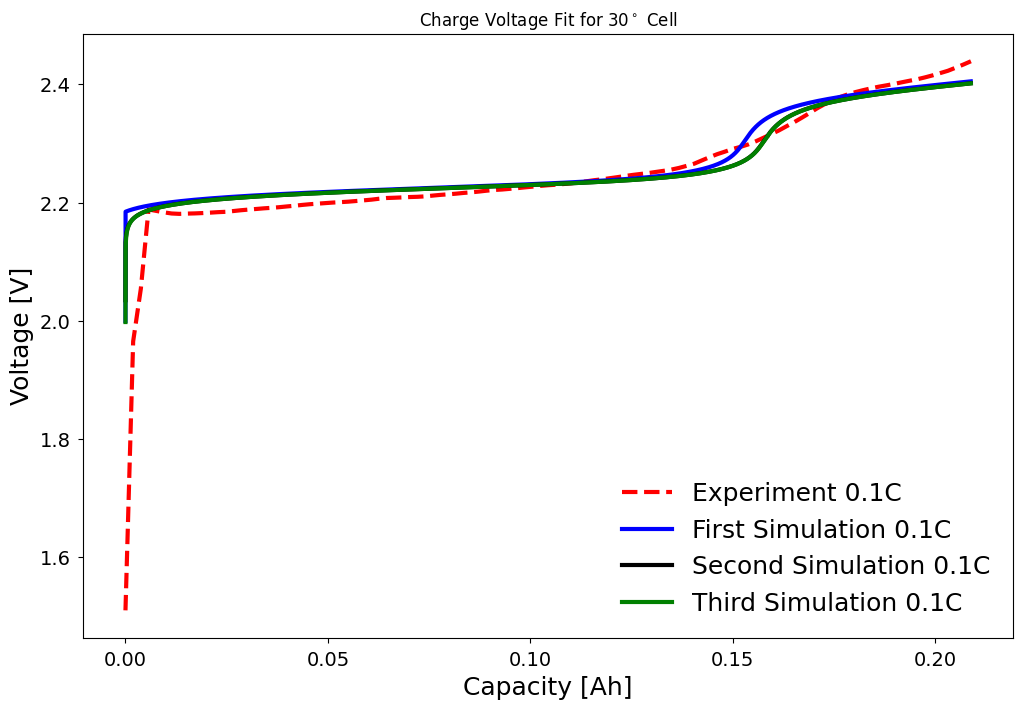

In [17]:
# get experimental data
filename = 'Cornish & Marinescu (2021)/vol_data'
infile = open(filename,'rb')
data_dict = pickle.load(infile)
infile.close()

discharge_data = data_dict['discharge']
charge_data = data_dict['charge']

plt.plot(charge_data['30']['capacity'],charge_data['30']['internal voltage'], linestyle='--')

index_30 = len(sim_30_cha1.solution.t[sim_30_cha1.solution.t*0.0211/3600 < charge_data['30']['capacity'][-1]])
capacity = abs(I)*sim_30_cha1.solution.t[:index_30]/3600
voltage = sim_30_cha1.solution['Terminal voltage [V]'].entries[:index_30]
plt.plot(capacity, voltage)

index_30 = len(sim_30_cha2.solution.t[sim_30_cha2.solution.t*0.0211/3600 < charge_data['30']['capacity'][-1]])
capacity = abs(I)*sim_30_cha2.solution.t[:index_30]/3600
voltage = sim_30_cha2.solution['Terminal voltage [V]'].entries[:index_30]
plt.plot(capacity, voltage)

index_30 = len(sim_30_cha3.solution.t[sim_30_cha3.solution.t*0.0211/3600 < charge_data['30']['capacity'][-1]])
capacity = abs(I)*sim_30_cha3.solution.t[:index_30]/3600
voltage = sim_30_cha3.solution['Terminal voltage [V]'].entries[:index_30]
plt.plot(capacity, voltage)

plt.title("Charge Voltage Fit for $30^\circ$ Cell")
plt.legend(['Experiment 0.1C', 'First Simulation 0.1C', 'Second Simulation 0.1C', 'Third Simulation 0.1C'], loc = 'lower right', frameon=False)
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]');

## 1.1.6 Third Discharge 

In [18]:
loc = index_30
S1_initial_30_dis3 = sim_30_cha3.solution['S [g]'].entries[loc]
S2_initial_30_dis3 = sim_30_cha3.solution['S2 [g]'].entries[loc]
S4_initial_30_dis3 = sim_30_cha3.solution['S4 [g]'].entries[loc]
S8_initial_30_dis3 = sim_30_cha3.solution['S8 [g]'].entries[loc]
Sp_initial_30_dis3 = sim_30_cha3.solution['Precipitated Sulfur [g]'].entries[loc]
V_initial_30_dis3 = sim_30_cha3.solution['Terminal voltage [V]'].entries[loc]
print(S8_initial_30_dis3)
print(S4_initial_30_dis3)
print(S2_initial_30_dis3)
print(S1_initial_30_dis3)
print(Sp_initial_30_dis3)
print(V_initial_30_dis3)

0.0003173516380710833
0.13159013673831138
0.300741792789352
1.064770693507289e-09
0.009838684146675655
2.401822383647025


In [19]:
model_30_dis3 = models.Cornish2021()

param_30_dis3 = model_30_dis2.default_parameter_values

# dissolution rate
kp_30 = 50
param_30_dis3.update(
    {
        "Current function [A]": 2*.0211,
        "Initial Condition for Terminal Voltage [V]": V_initial_30_dis3,
        "Initial Condition for S8 ion [g]" : S8_initial_30_dis3,
        "Initial Condition for S4 ion [g]" : S4_initial_30_dis3,
        "Initial Condition for S2 ion [g]" : S2_initial_30_dis3,
        "Initial Condition for S ion [g]" : S1_initial_30_dis3,
        "Initial Condition for Precipitated Sulfur [g]" : Sp_initial_30_dis3,
        "Lower voltage cut-off [V]" : 1.2,
        "Upper voltage cut-off [V]" : 2.5,
        "Standard Potential L [V]" : EL0,
        "Standard Potential M [V]" : EM0,
        "Standard Potential H [V]" : EH0,
        "Exchange current density L [A.m-2]": il0,
        "Exchange current density M [A.m-2]": im0,
        "Exchange current density H [A.m-2]": ih0,
        "Active reaction area per cell [m2]":ar,
        "S saturation mass [g]": S_star_30,
        'Precipitation rate [s-1]': kp_30,
        'Reference Temperature [K]': T_30
        }
)


sim_30_dis3 = pybamm.Simulation(
    model_30_dis3,
    parameter_values = param_30_dis3,
    solver=pybamm.CasadiSolver(
        atol=1e-8,
        rtol=1e-6,
        dt_max = .01,
        #extra_options_setup={"max_step_size": 0.1}, 
        max_step_decrease_count = 15,
    ),
)

sim_30_dis3 = run_simulation(sim_30_dis3, time_in_seconds = 17815)

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 2348.56 and h

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 17809.1 and h

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 17812.1 and h

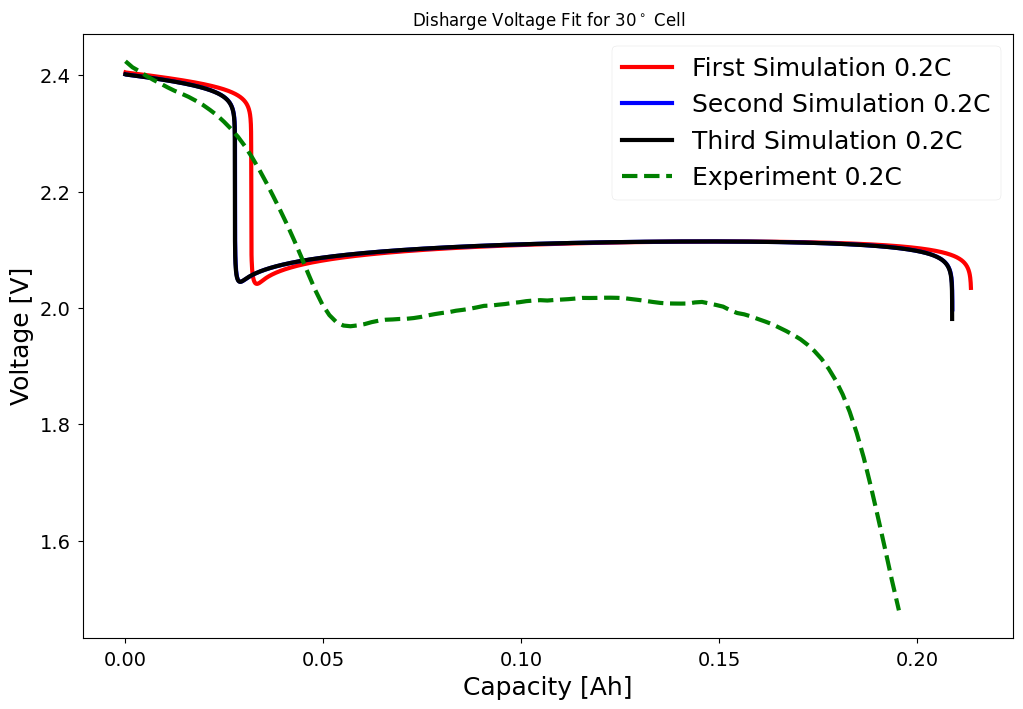

In [20]:
plt.plot(sim_30_dis1.solution.t*0.0422/3600, sim_30_dis1.solution['Terminal voltage [V]'].entries)

plt.plot(sim_30_dis2.solution.t*0.0422/3600, sim_30_dis2.solution['Terminal voltage [V]'].entries)

plt.plot(sim_30_dis3.solution.t*0.0422/3600, sim_30_dis3.solution['Terminal voltage [V]'].entries)

# get experimental data
filename = 'Cornish & Marinescu (2021)/vol_data'
infile = open(filename,'rb')
data_dict = pickle.load(infile)
infile.close()

discharge_data = data_dict['discharge']
charge_data = data_dict['charge']

plt.plot(discharge_data['30']['capacity'],discharge_data['30']['internal voltage'], linestyle='--')

plt.title("Disharge Voltage Fit for $30^\circ$ Cell")
plt.legend(["First Simulation 0.2C","Second Simulation 0.2C","Third Simulation 0.2C","Experiment 0.2C" ])
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]');

### We can compare the initial conditions for the first three charges

In [43]:
from tabulate import tabulate

table = [['Cycle Number', 'S8(t=0)','S4(t=0)','S2(t=0)','S(t=0)','Sp(t=0)'],
         ['1', '{:0.3e}'.format(S8_initial_cha_30),
               '{:0.3e}'.format(S4_initial_cha_30),
               '{:0.3e}'.format(S2_initial_cha_30),
               '{:0.3e}'.format(S1_initial_cha_30),
               '{:0.3e}'.format(Sp_initial_cha_30)],
         ['2', '{:0.3e}'.format(S8_initial_30_cha2), 
          '{:0.3e}'.format(S4_initial_30_cha2), 
          '{:0.3e}'.format(S2_initial_30_cha2),
          '{:0.3e}'.format(S1_initial_30_cha2),
          '{:0.3e}'.format(Sp_initial_30_cha2)],
         ['3', '{:0.3e}'.format(S8_initial_30_cha3), 
          '{:0.3e}'.format(S4_initial_30_cha3), 
          '{:0.3e}'.format(S2_initial_30_cha3),
          '{:0.3e}'.format(S1_initial_30_cha3),
          '{:0.3e}'.format(Sp_initial_30_cha3)]   
        ]

print(tabulate(table))


------------  ---------  ---------  ---------  ---------  ---------
Cycle Number  S8(t=0)    S4(t=0)    S2(t=0)    S(t=0)     Sp(t=0)
1             2.468e-63  8.425e-18  1.149e-02  1.000e-03  4.300e-01
2             2.918e-66  2.034e-20  1.495e-04  2.986e-05  4.423e-01
3             4.355e-76  4.201e-24  8.839e-06  2.985e-05  4.424e-01
------------  ---------  ---------  ---------  ---------  ---------


### We can compare the initial conditions for the first three discharges

In [46]:
table = [['Cycle Number', 'S8(t=0)','S4(t=0)','S2(t=0)','S(t=0)','Sp(t=0)'],
         ['1', '{:0.3e}'.format(S8_initial_30_dis1),
               '{:0.3e}'.format(S4_initial_30_dis1),
               '{:0.3e}'.format(S2_initial_30_dis1),
               '{:0.3e}'.format(S1_initial_30_dis1),
               '{:0.3e}'.format(Sp_initial_30_dis1)],
         ['2', '{:0.3e}'.format(S8_initial_30_dis1), 
          '{:0.3e}'.format(S4_initial_30_dis2), 
          '{:0.3e}'.format(S2_initial_30_dis2),
          '{:0.3e}'.format(S1_initial_30_dis2),
          '{:0.3e}'.format(Sp_initial_30_dis2)],
         ['3', '{:0.3e}'.format(S8_initial_30_dis3), 
          '{:0.3e}'.format(S4_initial_30_dis3), 
          '{:0.3e}'.format(S2_initial_30_dis3),
          '{:0.3e}'.format(S1_initial_30_dis3),
          '{:0.3e}'.format(Sp_initial_30_dis3)]   
        ]

print(tabulate(table))

------------  ---------  ---------  ---------  ---------  ---------
Cycle Number  S8(t=0)    S4(t=0)    S2(t=0)    S(t=0)     Sp(t=0)
1             6.987e-04  1.507e-01  2.828e-01  9.071e-10  8.221e-03
2             6.987e-04  1.318e-01  3.005e-01  1.063e-09  9.817e-03
3             3.174e-04  1.316e-01  3.007e-01  1.065e-09  9.839e-03
------------  ---------  ---------  ---------  ---------  ---------


## 1.2.1 First Charge at $40^\circ$C

In [54]:
# Experimental cell capacity
cap = 0.211

# Parameters taken from Marinescu et al. (2016)
Ms = 32
F = 9.649e4
R = 8.3145
T_40 = 303.15 + 10
ar = 0.960
nu = 0.0114

f_h = ((4 ** 2) * Ms * nu / 8)**(1/4)
f_m = ((2 ** 2) * Ms * nu / 4)**(1/2)
f_l = ((1 ** 2) * Ms * nu / 2)**(1/2)

# Current at 0.1C rate
I = -cap*0.1

# New standard potentials
EL0 = 1.9
EM0 = 2.41
EH0 = 2.43

# Exchange current constants
ih0 = 5
im0 = 5
il0 = 5

# Saturation mass constant
S_star_40 = 1e-6

# dissolution rate
kd_40 = 15000

# shuttle rate
ks_40 = 1e-3

# Initial value of S1 anion at start of charge
S1_initial_cha_40 = 5e-4

# Initial value of voltage at start of charge
V_initial_cha = 2.0

# Function for which root yields i_L = I
def S2_func(S1):
    constant = np.exp((2*F/(R*T_40))*(V_initial_cha - (2*R*T_40/F)*np.arcsinh(I/(-2*ar*il0)) - EL0 ))/(f_l**2)
    return constant*(S1**2)

# Function from equation (9b) in Cornish & Marinescu (2021)
def S4_func(S2):
    constant = np.exp((2*F/(R*T_40))*(V_initial_cha  - EM0 ))/(f_m**2)
    return constant*(S2**2)

# Function from equation (9a) in Cornish & Marinescu (2021)
def S8_func(S4):
    constant = np.exp((4*F/(R*T_40))*(V_initial_cha - EH0 ))/(f_h**4)
    return constant*(S4**2)

# Initial charge value of S2
S2_initial_cha_40 = S2_func(S1_initial_cha_40)

# Initial charge value of S2
S4_initial_cha_40 = S4_func(S2_initial_cha_40)

# Initial charge value of S2
S8_initial_cha_40 = S8_func(S4_initial_cha_40)

# Initial value of Precipitated sulfur at start of charge
# mass conservation across cells
Sp_initial_cha_40 = (S8_initial_cha_30 + 
                     S4_initial_cha_30 + 
                     S2_initial_cha_30 + 
                     S1_initial_cha_30 + 
                     Sp_initial_cha_30) - (S8_initial_cha_40 +
                                          S4_initial_cha_40 + 
                                          S2_initial_cha_40 + 
                                          S1_initial_cha_40)

# Initial high plateau potential 
EH_40 = EH0 + (R*T_40)*np.log(f_h*(S8_initial_cha_40**(1/4))/(S4_initial_cha_40**(1/2)))/(F)

# Initial high plateau over-potential
eta_H_40 = V_initial_cha - EH_40

# Initial high plateau current
iH_40 = -2*ih0*ar*np.sinh(F*eta_H_40/(2*R*T_40))

# Initial middle plateau potential
EM_40 = EM0 + (R*T_40)*np.log(f_m*(S4_initial_cha_40**(1/2))/S2_initial_cha_40)/(F)

# Initial middle plateau over-potentia
eta_M_40 = V_initial_cha - EM_40

# Initial middle plateau current
iM_40 = -2*im0*ar*np.sinh(F*eta_M_40/(2*R*T_40))

# Initial low plateau potential
EL_40 = EL0 + (R*T_40/F)*np.log(f_l*(S2_initial_cha_40**(1/2))/S1_initial_cha_40)

# Initial low plateau over-potentia
eta_L_40 = V_initial_cha - EL_40

# Initial low plateau current
iL_40 = -2*il0*ar*np.sinh(F*eta_L_40/(2*R*T_40))

print('The initial charge value of precipitated sulfur is {} g'.format(Sp_initial_cha_40))
print('The initial charge value of S1 anion is {} g'.format(S1_initial_cha_40))
print('The initial charge value of S2 anion is {} g'.format(S2_initial_cha_40))
print('The initial charge value of S4 anion is {} g'.format(S4_initial_cha_40))
print('The initial charge value of S8 anion is {} g'.format(S8_initial_cha_40))
print('The initial charge value of voltage is {} V'.format(V_initial_cha))
print('The initial charge value of the high plateau potential is {} V'.format(EH_40))
print('The initial charge value of the high plateau over-potential is {} V'.format(eta_H_40))
print('The initial charge value of the high plateau current is {} A'.format(iH_40))
print('The initial charge value of the middle plateau potential is {} V'.format(EM_40))
print('The initial charge value of the middle plateau over-potential is {} V'.format(eta_M_40))
print('The initial charge value of the middle plateau current is {} A'.format(iM_40))
print('The initial charge value of the low plateau potential is {} V'.format(EL_40))
print('The initial charge value of the low plateau over-potential is {} V'.format(eta_L_40))
print('The initial charge value of the low plateau current is {} A'.format(iL_40))

The initial charge value of precipitated sulfur is 0.43973890521650266 g
The initial charge value of S1 anion is 0.0005 g
The initial charge value of S2 anion is 0.0022490611606826006 g
The initial charge value of S4 anion is 8.79914013972896e-19 g
The initial charge value of S8 anion is 2.204037630370135e-64 g
The initial charge value of voltage is 2.0 V
The initial charge value of the high plateau potential is 2.0 V
The initial charge value of the high plateau over-potential is 0.0 V
The initial charge value of the high plateau current is -0.0 A
The initial charge value of the middle plateau potential is 2.0 V
The initial charge value of the middle plateau over-potential is 0.0 V
The initial charge value of the middle plateau current is -0.0 A
The initial charge value of the low plateau potential is 1.9998813829509319 V
The initial charge value of the low plateau over-potential is 0.00011861704906812598 V
The initial charge value of the low plateau current is -0.021099999999991376 A


In [55]:
# Instantiate the model
model_40 = models.Cornish2021()

# Obtain model parameter dictionary
param_40 = model_40.default_parameter_values

# Update the parameters for charge
param_40.update(
    {
        "Current function [A]": I,
        "Initial Condition for Terminal Voltage [V]": V_initial_cha,
        "Initial Condition for S8 ion [g]" : S8_initial_cha_40,
        "Initial Condition for S4 ion [g]" : S4_initial_cha_40,
        "Initial Condition for S2 ion [g]" : S2_initial_cha_40,
        "Initial Condition for S ion [g]" : S1_initial_cha_40,
        "Initial Condition for Precipitated Sulfur [g]" : Sp_initial_cha_40,
        "Lower voltage cut-off [V]" : 1.2,
        "Upper voltage cut-off [V]" : 2.5,
        "Standard Potential L [V]" : EL0,
        "Standard Potential M [V]" : EM0,
        "Standard Potential H [V]" : EH0,
        "Exchange current density L [A.m-2]": il0,
        "Exchange current density M [A.m-2]": im0,
        "Exchange current density H [A.m-2]": ih0,
        "Active reaction area per cell [m2]":ar,
        "S saturation mass [g]": S_star_40,
        'Shuttle rate coefficient during charge [s-1]': ks_40,
        'Dissolution rate [s-1]': kd_40,
        'Reference Temperature [K]': T_40,
        }
)

# Instantiate simulation object 
sim_40_cha1 = pybamm.Simulation(
    model_40,
    parameter_values = param_40,
    solver=pybamm.CasadiSolver(
        atol=1e-6,
        rtol=1e-6,
        dt_max = .01,
        extra_options_setup={"max_step_size": 0.1}, 
        max_step_decrease_count = 15,
    ),
)

# Run simulation
sim_40_cha1 = run_simulation(sim_40_cha1)


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

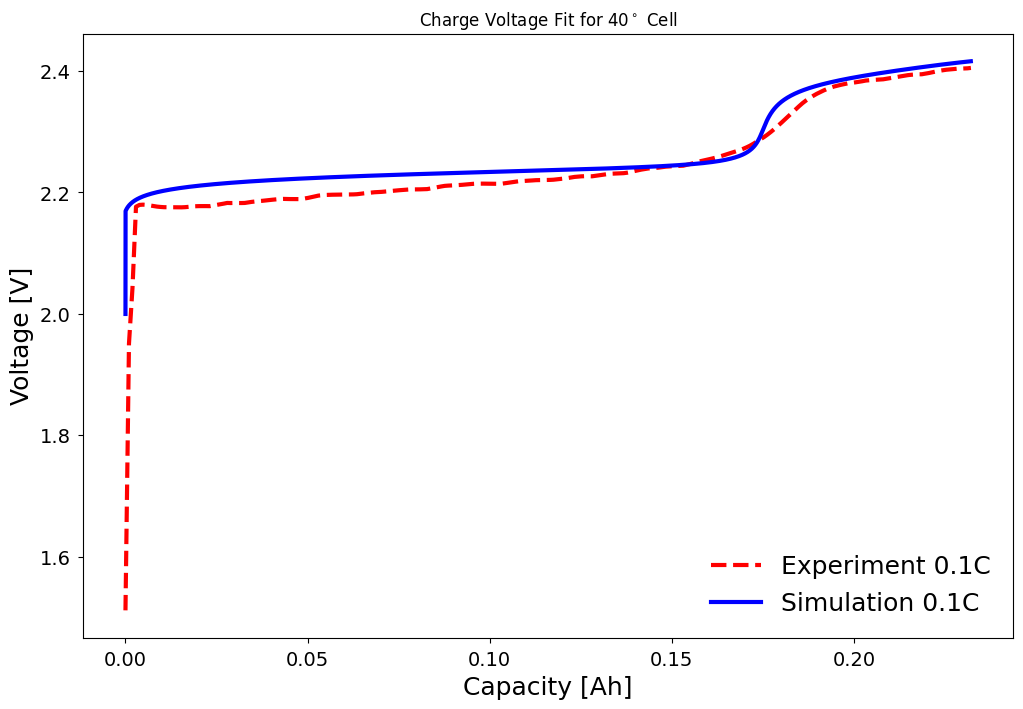

In [56]:
# get experimental data
filename = 'Cornish & Marinescu (2021)/vol_data'
infile = open(filename,'rb')
data_dict = pickle.load(infile)
infile.close()

discharge_data = data_dict['discharge']
charge_data = data_dict['charge']

index_40 = len(sim_40_cha1.solution.t[sim_40_cha1.solution.t*0.0211/3600 < charge_data['40']['capacity'][-1] ])

capacity = abs(I)*sim_40_cha1.solution.t[:index_40]/3600
voltage = sim_40_cha1.solution['Terminal voltage [V]'].entries[:index_40]

plt.plot(charge_data['40']['capacity'],charge_data['40']['internal voltage'], linestyle='--')

plt.title("Charge Voltage Fit for $40^\circ$ Cell")
plt.plot(capacity, voltage)
plt.legend(['Experiment 0.1C', 'First Simulation 0.1C'], loc = 'lower right', frameon=False)
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]');

## 1.2.2 First Disharge at $40^\circ$C

In [60]:
loc = index_40
S1_initial_40_dis1 = sim_40_cha1.solution['S [g]'].entries[loc]
S2_initial_40_dis1 = sim_40_cha1.solution['S2 [g]'].entries[loc]
S4_initial_40_dis1 = sim_40_cha1.solution['S4 [g]'].entries[loc]
S8_initial_40_dis1 = sim_40_cha1.solution['S8 [g]'].entries[loc]
Sp_initial_40_dis1 = sim_40_cha1.solution['Precipitated Sulfur [g]'].entries[loc]
V_initial_40_dis1 = sim_40_cha1.solution['Terminal voltage [V]'].entries[loc]
print(S8_initial_40_dis1)
print(S4_initial_40_dis1)
print(S2_initial_40_dis1)
print(S1_initial_40_dis1)
print(Sp_initial_40_dis1)
print(V_initial_40_dis1)

0.007752820866508144
0.21183675467989385
0.22285981500305924
9.982267831697343e-10
3.8574829510168196e-05
2.41605554744238


In [61]:
model_40_dis1 = models.Cornish2021()

# precipitation rate
kp_40 = 30

param_40_dis1 = model_40_dis1.default_parameter_values
param_40_dis1.update(
    {
        "Current function [A]": 2*.0211,
        "Initial Condition for Terminal Voltage [V]": V_initial_40_dis1,
        "Initial Condition for S8 ion [g]" : S8_initial_40_dis1,
        "Initial Condition for S4 ion [g]" : S4_initial_40_dis1,
        "Initial Condition for S2 ion [g]" : S2_initial_40_dis1,
        "Initial Condition for S ion [g]" : S1_initial_40_dis1,
        "Initial Condition for Precipitated Sulfur [g]" : Sp_initial_40_dis1,
        "Lower voltage cut-off [V]" : 1.2,
        "Upper voltage cut-off [V]" : 2.5,
        "Standard Potential L [V]" : EL0,
        "Standard Potential M [V]" : EM0,
        "Standard Potential H [V]" : EH0,
        "Exchange current density L [A.m-2]": il0,
        "Exchange current density M [A.m-2]": im0,
        "Exchange current density H [A.m-2]": ih0,
        "Active reaction area per cell [m2]":ar,
        "S saturation mass [g]": S_star_40,
        'Precipitation rate [s-1]': kp_40,
        'Reference Temperature [K]': T_40
        }
)


sim_40_dis1 = pybamm.Simulation(
    model_40_dis1,
    parameter_values = param_40_dis1,
    solver=pybamm.CasadiSolver(
        atol=1e-8,
        rtol=1e-6,
        dt_max = .01,
        extra_options_setup={"max_step_size": 0.01}, 
        max_step_decrease_count = 15,
    ),
)

sim_40_dis1 = run_simulation(sim_40_dis1, time_in_seconds = 19700)


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 4021.37 and h = 9.53674e-09, the corrector convergence failed repeatedly or with |h| = hmin.
psetup failed: ...

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 4052.53 and h

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 4144.85 and h

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 4239.61 and h = 9.53674e-09, the corrector convergence failed repeatedly or with |h| = hmin.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: ...

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 4319.43 and h = 4.76837e-09, the corrector convergence failed repeatedly or with |h| = hmin.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: ...

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 4582.61 and h = 9.53674e-09, the corrector convergence failed repeatedly or with |h| = hmin.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: ...

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 4668.96 and h

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 19603.4 and h = 4.76837e-09, the corrector convergence failed repeatedly or with |h| = hmin.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: ...

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

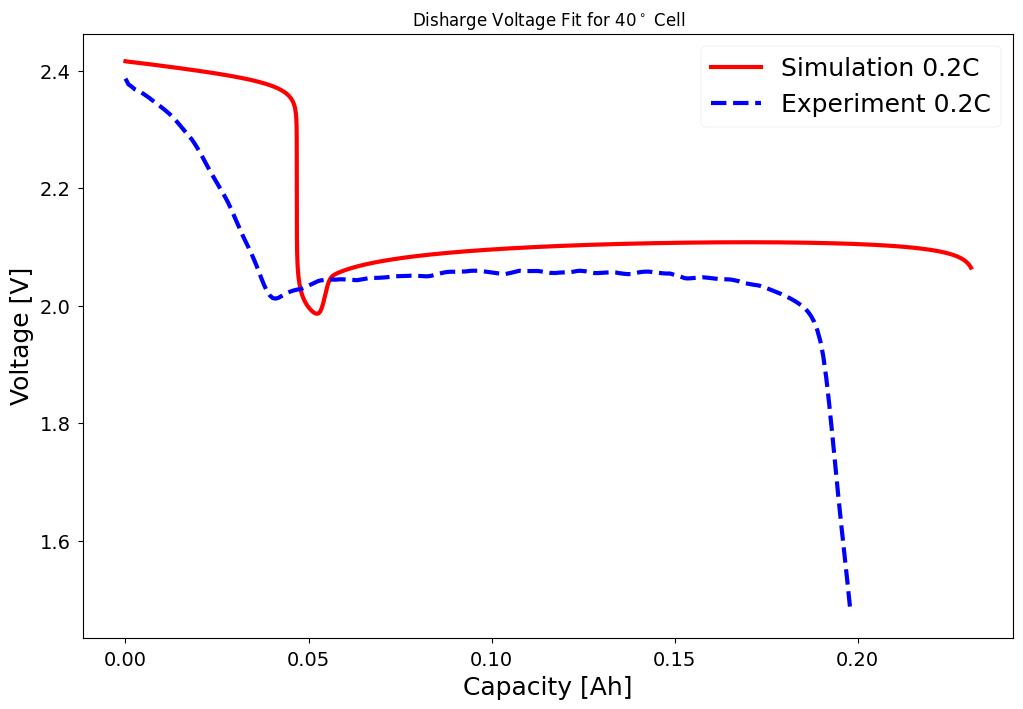

In [62]:
plt.plot(sim_40_dis1.solution.t*0.0422/3600, sim_40_dis1.solution['Terminal voltage [V]'].entries)

# get experimental data
filename = 'Cornish & Marinescu (2021)/vol_data'
infile = open(filename,'rb')
data_dict = pickle.load(infile)
infile.close()

discharge_data = data_dict['discharge']
charge_data = data_dict['charge']

plt.plot(discharge_data['40']['capacity'],discharge_data['40']['internal voltage'], linestyle='--')

plt.title("Disharge Voltage Fit for $40^\circ$ Cell")
plt.legend(["First Simulation 0.2C","Experiment 0.2C" ])
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]');

## 1.2.3 Second Charge at $40^\circ$C

In [63]:
loc = index_40
S1_initial_40_cha2 = sim_40_cha1.solution['S [g]'].entries[loc]
S2_initial_40_cha2 = sim_40_cha1.solution['S2 [g]'].entries[loc]
S4_initial_40_cha2 = sim_40_cha1.solution['S4 [g]'].entries[loc]
S8_initial_40_cha2 = sim_40_cha1.solution['S8 [g]'].entries[loc]
Sp_initial_40_cha2 = sim_40_cha1.solution['Precipitated Sulfur [g]'].entries[loc]
V_initial_40_cha2 = sim_40_cha1.solution['Terminal voltage [V]'].entries[loc]
print(S8_initial_40_cha2)
print(S4_initial_40_cha2)
print(S2_initial_40_cha2)
print(S1_initial_40_cha2)
print(Sp_initial_40_cha2)
print(V_initial_40_cha2)

0.007752820866508144
0.21183675467989385
0.22285981500305924
9.982267831697343e-10
3.8574829510168196e-05
2.41605554744238


In [64]:
# Instantiate the model
model_40 = models.Cornish2021()

# Obtain model parameter dictionary
param_40 = model_40.default_parameter_values

# Update the parameters for charge
param_40.update(
    {
        "Current function [A]": I,
        "Initial Condition for Terminal Voltage [V]": V_initial_40_cha2,
        "Initial Condition for S8 ion [g]" : S8_initial_40_cha2,
        "Initial Condition for S4 ion [g]" : S4_initial_40_cha2,
        "Initial Condition for S2 ion [g]" : S2_initial_40_cha2,
        "Initial Condition for S ion [g]" : S1_initial_40_cha2,
        "Initial Condition for Precipitated Sulfur [g]" : Sp_initial_40_cha2,
        "Lower voltage cut-off [V]" : 1.2,
        "Upper voltage cut-off [V]" : 2.5,
        "Standard Potential L [V]" : EL0,
        "Standard Potential M [V]" : EM0,
        "Standard Potential H [V]" : EH0,
        "Exchange current density L [A.m-2]": il0,
        "Exchange current density M [A.m-2]": im0,
        "Exchange current density H [A.m-2]": ih0,
        "Active reaction area per cell [m2]":ar,
        "S saturation mass [g]": S_star_40,
        'Shuttle rate coefficient during charge [s-1]': ks_40,
        'Dissolution rate [s-1]': kd_40,
        'Reference Temperature [K]': T_40,
        }
)

# Instantiate simulation object 
sim_40_cha2 = pybamm.Simulation(
    model_40,
    parameter_values = param_40,
    solver=pybamm.CasadiSolver(
        atol=1e-6,
        rtol=1e-6,
        dt_max = .01,
        extra_options_setup={"max_step_size": 0.1}, 
        max_step_decrease_count = 15,
    ),
)

# Run simulation
sim_40_cha2 = run_simulation(sim_40_cha2)


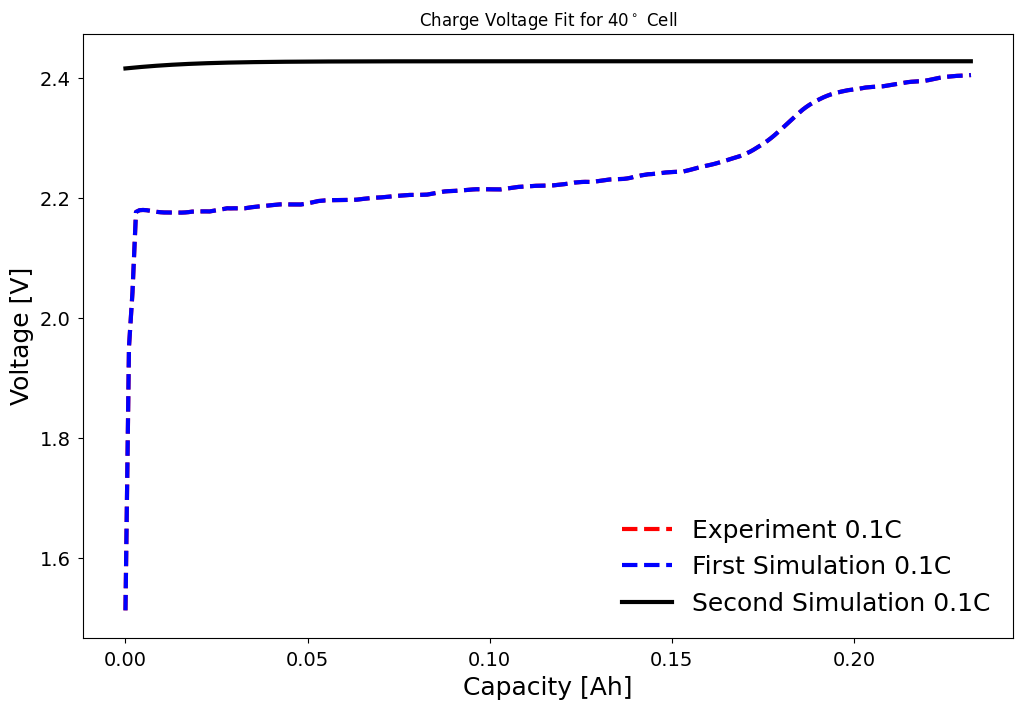

In [66]:
# get experimental data
filename = 'Cornish & Marinescu (2021)/vol_data'
infile = open(filename,'rb')
data_dict = pickle.load(infile)
infile.close()

discharge_data = data_dict['discharge']
charge_data = data_dict['charge']

# Plot first charge
index_40 = len(sim_40_cha1.solution.t[sim_40_cha1.solution.t*0.0211/3600 < charge_data['40']['capacity'][-1] ])
capacity = abs(I)*sim_40_cha1.solution.t[:index_40]/3600
voltage = sim_40_cha1.solution['Terminal voltage [V]'].entries[:index_40]
plt.plot(charge_data['40']['capacity'],charge_data['40']['internal voltage'], linestyle='--')

# Plot second charge
index_40 = len(sim_40_cha2.solution.t[sim_40_cha2.solution.t*0.0211/3600 < charge_data['40']['capacity'][-1] ])
capacity = abs(I)*sim_40_cha2.solution.t[:index_40]/3600
voltage = sim_40_cha2.solution['Terminal voltage [V]'].entries[:index_40]
plt.plot(charge_data['40']['capacity'],charge_data['40']['internal voltage'], linestyle='--')

plt.title("Charge Voltage Fit for $40^\circ$ Cell")
plt.plot(capacity, voltage)
plt.legend(['Experiment 0.1C', 'First Simulation 0.1C', 'Second Simulation 0.1C'], loc = 'lower right', frameon=False)
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]');

## 1.2.4 Second Disharge at $40^\circ$C

In [60]:
loc = index_40
S1_initial_40_dis2 = sim_40_cha2.solution['S [g]'].entries[loc]
S2_initial_40_dis2 = sim_40_cha2.solution['S2 [g]'].entries[loc]
S4_initial_40_dis2 = sim_40_cha2.solution['S4 [g]'].entries[loc]
S8_initial_40_dis2 = sim_40_cha2.solution['S8 [g]'].entries[loc]
Sp_initial_40_dis2 = sim_40_cha2.solution['Precipitated Sulfur [g]'].entries[loc]
V_initial_40_dis2 = sim_40_cha2.solution['Terminal voltage [V]'].entries[loc]
print(S8_initial_40_dis2)
print(S4_initial_40_dis2)
print(S2_initial_40_dis2)
print(S1_initial_40_dis2)
print(Sp_initial_40_dis2)
print(V_initial_40_dis2)

0.007752820866508144
0.21183675467989385
0.22285981500305924
9.982267831697343e-10
3.8574829510168196e-05
2.41605554744238


In [61]:
model_40_dis2 = models.Cornish2021()

# precipitation rate
kp_40 = 30

param_40_dis2 = model_40_dis1.default_parameter_values
param_40_dis1.update(
    {
        "Current function [A]": 2*.0211,
        "Initial Condition for Terminal Voltage [V]": V_initial_40_dis2,
        "Initial Condition for S8 ion [g]" : S8_initial_40_dis2,
        "Initial Condition for S4 ion [g]" : S4_initial_40_dis2,
        "Initial Condition for S2 ion [g]" : S2_initial_40_dis2,
        "Initial Condition for S ion [g]" : S1_initial_40_dis2,
        "Initial Condition for Precipitated Sulfur [g]" : Sp_initial_40_dis2,
        "Lower voltage cut-off [V]" : 1.2,
        "Upper voltage cut-off [V]" : 2.5,
        "Standard Potential L [V]" : EL0,
        "Standard Potential M [V]" : EM0,
        "Standard Potential H [V]" : EH0,
        "Exchange current density L [A.m-2]": il0,
        "Exchange current density M [A.m-2]": im0,
        "Exchange current density H [A.m-2]": ih0,
        "Active reaction area per cell [m2]":ar,
        "S saturation mass [g]": S_star_40,
        'Precipitation rate [s-1]': kp_40,
        'Reference Temperature [K]': T_40
        }
)


sim_40_dis2 = pybamm.Simulation(
    model_40_dis2,
    parameter_values = param_40_dis2,
    solver=pybamm.CasadiSolver(
        atol=1e-8,
        rtol=1e-6,
        dt_max = .01,
        extra_options_setup={"max_step_size": 0.01}, 
        max_step_decrease_count = 15,
    ),
)

sim_40_dis2 = run_simulation(sim_40_dis2, time_in_seconds = 19700)


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 4021.37 and h = 9.53674e-09, the corrector convergence failed repeatedly or with |h| = hmin.
psetup failed: ...

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 4052.53 and h

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 4144.85 and h

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 4239.61 and h = 9.53674e-09, the corrector convergence failed repeatedly or with |h| = hmin.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: ...

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 4319.43 and h = 4.76837e-09, the corrector convergence failed repeatedly or with |h| = hmin.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: ...

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 4582.61 and h = 9.53674e-09, the corrector convergence failed repeatedly or with |h| = hmin.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: ...

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 4668.96 and h

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 19603.4 and h = 4.76837e-09, the corrector convergence failed repeatedly or with |h| = hmin.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: ...

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

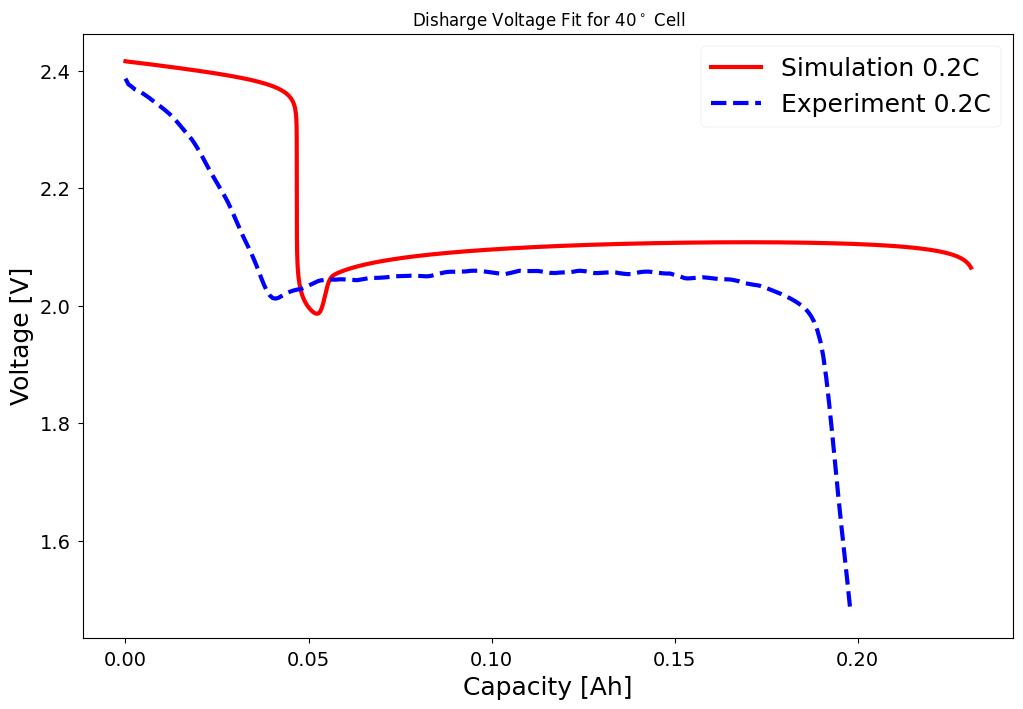

In [62]:
plt.plot(sim_40_dis1.solution.t*0.0422/3600, sim_40_dis1.solution['Terminal voltage [V]'].entries)
plt.plot(sim_40_dis2.solution.t*0.0422/3600, sim_40_dis2.solution['Terminal voltage [V]'].entries)

# get experimental data
filename = 'Cornish & Marinescu (2021)/vol_data'
infile = open(filename,'rb')
data_dict = pickle.load(infile)
infile.close()

discharge_data = data_dict['discharge']
charge_data = data_dict['charge']

plt.plot(discharge_data['40']['capacity'],discharge_data['40']['internal voltage'], linestyle='--')


plt.title("Disharge Voltage Fit for $40^\circ$ Cell")
plt.legend(["First Simulation 0.2C","Second Simulation 0.2C","Experiment 0.2C" ])
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]');

In [ ]:
## 1.2.5 Third Charge at $20^\circ$C

In [ ]:
## 1.2.1 Third Disharge at $20^\circ$C

### We can compare the initial conditions for the first three charges at $20^\circ$C

In [ ]:
table = [['Cycle Number', 'S8(t=0)','S4(t=0)','S2(t=0)','S(t=0)','Sp(t=0)'],
         ['1', '{:0.3e}'.format(S8_initial_cha_30),
               '{:0.3e}'.format(S4_initial_cha_30),
               '{:0.3e}'.format(S2_initial_cha_30),
               '{:0.3e}'.format(S1_initial_cha_30),
               '{:0.3e}'.format(Sp_initial_cha_30)],
         ['2', '{:0.3e}'.format(S8_initial_30_cha2), 
          '{:0.3e}'.format(S4_initial_30_cha2), 
          '{:0.3e}'.format(S2_initial_30_cha2),
          '{:0.3e}'.format(S1_initial_30_cha2),
          '{:0.3e}'.format(Sp_initial_30_cha2)],
         ['3', '{:0.3e}'.format(S8_initial_30_cha3), 
          '{:0.3e}'.format(S4_initial_30_cha3), 
          '{:0.3e}'.format(S2_initial_30_cha3),
          '{:0.3e}'.format(S1_initial_30_cha3),
          '{:0.3e}'.format(Sp_initial_30_cha3)]   
        ]

print(tabulate(table))

### We can compare the initial conditions for the first three discharges at $20^\circ$C

In [ ]:
table = [['Cycle Number', 'S8(t=0)','S4(t=0)','S2(t=0)','S(t=0)','Sp(t=0)'],
         ['1', '{:0.3e}'.format(S8_initial_30_dis1),
               '{:0.3e}'.format(S4_initial_30_dis1),
               '{:0.3e}'.format(S2_initial_30_dis1),
               '{:0.3e}'.format(S1_initial_30_dis1),
               '{:0.3e}'.format(Sp_initial_30_dis1)],
         ['2', '{:0.3e}'.format(S8_initial_30_dis1), 
          '{:0.3e}'.format(S4_initial_30_dis2), 
          '{:0.3e}'.format(S2_initial_30_dis2),
          '{:0.3e}'.format(S1_initial_30_dis2),
          '{:0.3e}'.format(Sp_initial_30_dis2)],
         ['3', '{:0.3e}'.format(S8_initial_30_dis3), 
          '{:0.3e}'.format(S4_initial_30_dis3), 
          '{:0.3e}'.format(S2_initial_30_dis3),
          '{:0.3e}'.format(S1_initial_30_dis3),
          '{:0.3e}'.format(Sp_initial_30_dis3)]   
        ]

print(tabulate(table))

## 1.2.1 First Charge at $20^\circ$C

## 1.2.2 First Disharge at $20^\circ$C

In [ ]:
## 1.2.3 Second Charge at $20^\circ$C

In [ ]:
## 1.2.4 Second Disharge at $20^\circ$C

In [ ]:
## 1.2.5 Third Charge at $20^\circ$C

In [ ]:
## 1.2.1 Third Disharge at $20^\circ$C

### We can compare the initial conditions for the first three charges at $20^\circ$C

In [ ]:
table = [['Cycle Number', 'S8(t=0)','S4(t=0)','S2(t=0)','S(t=0)','Sp(t=0)'],
         ['1', '{:0.3e}'.format(S8_initial_cha_30),
               '{:0.3e}'.format(S4_initial_cha_30),
               '{:0.3e}'.format(S2_initial_cha_30),
               '{:0.3e}'.format(S1_initial_cha_30),
               '{:0.3e}'.format(Sp_initial_cha_30)],
         ['2', '{:0.3e}'.format(S8_initial_30_cha2), 
          '{:0.3e}'.format(S4_initial_30_cha2), 
          '{:0.3e}'.format(S2_initial_30_cha2),
          '{:0.3e}'.format(S1_initial_30_cha2),
          '{:0.3e}'.format(Sp_initial_30_cha2)],
         ['3', '{:0.3e}'.format(S8_initial_30_cha3), 
          '{:0.3e}'.format(S4_initial_30_cha3), 
          '{:0.3e}'.format(S2_initial_30_cha3),
          '{:0.3e}'.format(S1_initial_30_cha3),
          '{:0.3e}'.format(Sp_initial_30_cha3)]   
        ]

print(tabulate(table))

### We can compare the initial conditions for the first three discharges at $20^\circ$C

In [ ]:
table = [['Cycle Number', 'S8(t=0)','S4(t=0)','S2(t=0)','S(t=0)','Sp(t=0)'],
         ['1', '{:0.3e}'.format(S8_initial_30_dis1),
               '{:0.3e}'.format(S4_initial_30_dis1),
               '{:0.3e}'.format(S2_initial_30_dis1),
               '{:0.3e}'.format(S1_initial_30_dis1),
               '{:0.3e}'.format(Sp_initial_30_dis1)],
         ['2', '{:0.3e}'.format(S8_initial_30_dis1), 
          '{:0.3e}'.format(S4_initial_30_dis2), 
          '{:0.3e}'.format(S2_initial_30_dis2),
          '{:0.3e}'.format(S1_initial_30_dis2),
          '{:0.3e}'.format(Sp_initial_30_dis2)],
         ['3', '{:0.3e}'.format(S8_initial_30_dis3), 
          '{:0.3e}'.format(S4_initial_30_dis3), 
          '{:0.3e}'.format(S2_initial_30_dis3),
          '{:0.3e}'.format(S1_initial_30_dis3),
          '{:0.3e}'.format(Sp_initial_30_dis3)]   
        ]

print(tabulate(table))

# 2.0 Discharge Resistance

We can take the resistance parameters from the parameter fitting notebook

In [47]:
alpha_20 = 0.024634015651791578
alpha_30 = 0.018940246434802206
alpha_40 = 0.01618530330123883
beta_20 = 0.20118782360997944
beta_30 = 0.22868479760040686
beta_40 = 0.2456295113566913

# 2.1 Discharge Resistance at $20^\circ$C

# 2.2 Discharge Resistance at $30^\circ$C

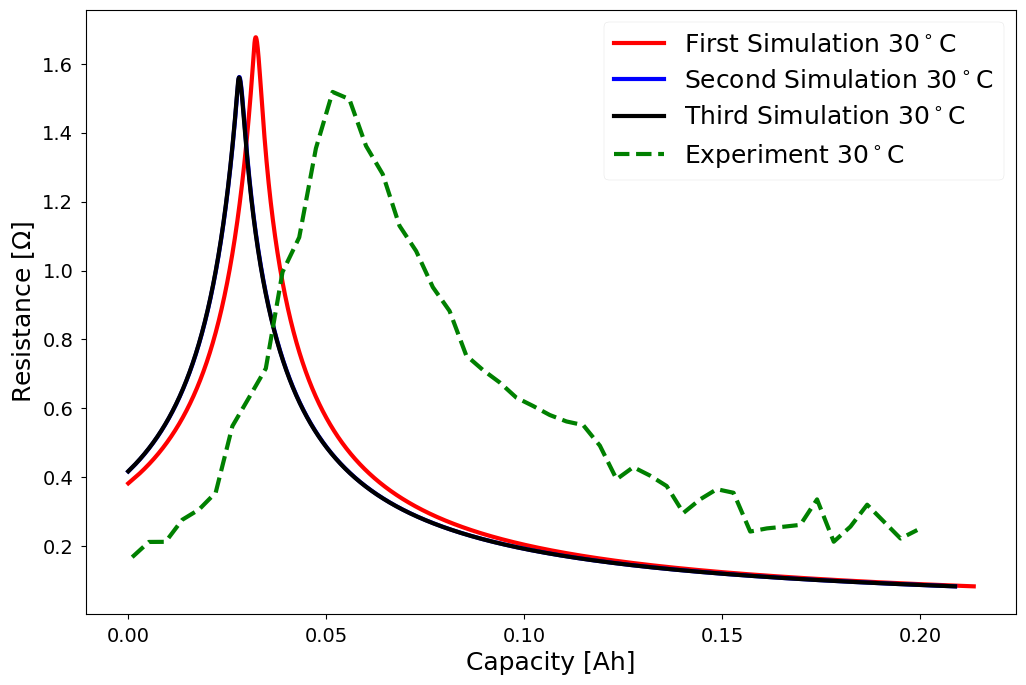

In [52]:
capacity_dis_30 = 2*.0211*sim_30_dis1.solution.t/3600
S4 = sim_30_dis1.solution['S4 [g]'].entries
S2 = sim_30_dis1.solution['S2 [g]'].entries
S1 = sim_30_dis1.solution['S [g]'].entries
Li_dis_30 = S1 + 0.5*S2 + 0.25*S4 
R_dis_30 = alpha_30/(beta_30 - Li_dis_30)
plt.plot(capacity_dis_30, R_dis_30)


capacity_dis_30 = 2*.0211*sim_30_dis2.solution.t/3600
S4 = sim_30_dis2.solution['S4 [g]'].entries
S2 = sim_30_dis2.solution['S2 [g]'].entries
S1 = sim_30_dis2.solution['S [g]'].entries
Li_dis_30 = S1 + 0.5*S2 + 0.25*S4 
R_dis_30 = alpha_30/(beta_30 - Li_dis_30)
plt.plot(capacity_dis_30, R_dis_30)

capacity_dis_30 = 2*.0211*sim_30_dis3.solution.t/3600
S4 = sim_30_dis3.solution['S4 [g]'].entries
S2 = sim_30_dis3.solution['S2 [g]'].entries
S1 = sim_30_dis3.solution['S [g]'].entries
Li_dis_30 = S1 + 0.5*S2 + 0.25*S4 
R_dis_30 = alpha_30/(beta_30 - Li_dis_30)
plt.plot(capacity_dis_30, R_dis_30)

filename = 'Cornish & Marinescu (2021)/res_data'
infile = open(filename,'rb')
res_data = pickle.load(infile)
infile.close()

res_discharge_data = res_data['discharge']
res_charge_data = res_data['charge']

plt.plot(res_discharge_data['30'][0],res_discharge_data['30'][1],linestyle='--', color = 'green')

plt.legend(["First Simulation $30^\circ$C",
            "Second Simulation $30^\circ$C",
            "Third Simulation $30^\circ$C",
            "Experiment $30^\circ$C"
            ])
plt.xlabel('Capacity [Ah]')
plt.ylabel('Resistance [$\Omega$]');



# 2.3 Discharge Resistance at $40^\circ$C

# 3 Charging Infinite Capacity/Voltage

# 4 Discharging Rate-Dependent Capacity \& Voltage

# 5 Depth-of-Discharge Depedent Charge Voltage Kink